In [107]:
pool_addr = "0x6f38e884725a116C9C7fBF208e79FE8828a2595F"
deposit_amount_usd = 1000
is_pair_toggled = False

In [108]:
import pandas as pd
import math
from decimal import Decimal, getcontext
import json

# Set high precision for accurate calculations
getcontext().prec = 50

In [109]:
class UniswapV3Calculator:
    def __init__(self, pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled=False):
        self.pool_day_data = pool_day_data.copy()
        self.pool_ticks_data = pool_ticks_data.copy()
        self.fee_tier = fee_tier
        self.token0_decimal = token0_decimal
        self.token1_decimal = token1_decimal
        if is_pair_toggled:
            self.token0_decimal, self.token1_decimal = self.token1_decimal, self.token0_decimal
        self.is_pair_toggled = is_pair_toggled
        
        # Q96 for precise calculations
        self.Q96 = Decimal(2) ** 96
        
        # Get current price (most recent close price)
        self.current_price = float(self.pool_day_data.iloc[0]['close'])
        print(f"Current price (token0/token1): {self.current_price:.12f}")
        print(f"Current price (token1/token0): {1/self.current_price:.2f}")
        
        # Sort ticks by tickIdx for liquidity calculation
        self.pool_ticks_data = self.pool_ticks_data.sort_values('tickIdx')
    
    def expand_decimals(self, n, exp):
        """Expand decimals"""
        return Decimal(str(n)) * (Decimal(10) ** exp)
    
    def mul_div(self, a, b, multiplier):
        """Multiply and divide"""
        return (Decimal(str(a)) * Decimal(str(b))) / Decimal(str(multiplier))
    
    def get_sqrt_price_x96(self, price):
        """Get sqrt price x96"""
        token0 = self.expand_decimals(price, self.token0_decimal)
        token1 = self.expand_decimals(1, self.token1_decimal)
        
        sqrt_ratio = (token0 / token1).sqrt()
        return sqrt_ratio * self.Q96
    
    def get_liquidity_for_amount0(self, sqrt_ratio_a_x96, sqrt_ratio_b_x96, amount0):
        """Get liquidity for amount0"""
        intermediate = self.mul_div(sqrt_ratio_b_x96, sqrt_ratio_a_x96, self.Q96)
        return self.mul_div(amount0, intermediate, sqrt_ratio_b_x96 - sqrt_ratio_a_x96)
    
    def get_liquidity_for_amount1(self, sqrt_ratio_a_x96, sqrt_ratio_b_x96, amount1):
        """Get liquidity for amount1"""
        return self.mul_div(amount1, self.Q96, sqrt_ratio_b_x96 - sqrt_ratio_a_x96)
    
    def calculate_position_liquidity(self, amount0, amount1, price_lower, price_upper, current_price):
        """Calculate position liquidity deltaL"""    
        P = current_price
        Pl = price_lower
        Pu = price_upper
        
        amt0 = self.expand_decimals(amount0, self.token1_decimal)
        amt1 = self.expand_decimals(amount1, self.token0_decimal)
        
        sqrt_ratio_x96 = self.get_sqrt_price_x96(P)
        sqrt_ratio_a_x96 = self.get_sqrt_price_x96(Pl)
        sqrt_ratio_b_x96 = self.get_sqrt_price_x96(Pu)
        
        if sqrt_ratio_x96 <= sqrt_ratio_a_x96:
            liquidity = self.get_liquidity_for_amount0(sqrt_ratio_a_x96, sqrt_ratio_b_x96, amt0)
        elif sqrt_ratio_x96 < sqrt_ratio_b_x96:
            liquidity0 = self.get_liquidity_for_amount0(sqrt_ratio_x96, sqrt_ratio_b_x96, amt0)
            liquidity1 = self.get_liquidity_for_amount1(sqrt_ratio_a_x96, sqrt_ratio_x96, amt1)
            liquidity = min(liquidity0, liquidity1)
        else:
            liquidity = self.get_liquidity_for_amount1(sqrt_ratio_a_x96, sqrt_ratio_b_x96, amt1)
        
        print(f"deltaL: {liquidity:.2e}")
        return float(liquidity)
    
    def get_tokens_amount_from_deposit_amount_usd(self, P, Pl, Pu, price_usd_x, price_usd_y, deposit_amount_usd):
        """Calculate token amounts from deposit amount USD"""
        if self.is_pair_toggled:
            price_usd_x, price_usd_y = price_usd_y, price_usd_x
        
        sqrt_P = math.sqrt(P)
        sqrt_Pl = math.sqrt(Pl)
        sqrt_Pu = math.sqrt(Pu)
        
        denominator = (sqrt_P - sqrt_Pl) * price_usd_y + (1/sqrt_P - 1/sqrt_Pu) * price_usd_x
        delta_l = deposit_amount_usd / denominator
        
        delta_y = delta_l * (sqrt_P - sqrt_Pl)
        if delta_y * price_usd_y < 0:
            delta_y = 0
        if delta_y * price_usd_y > deposit_amount_usd:
            delta_y = deposit_amount_usd / price_usd_y
        
        delta_x = delta_l * (1/sqrt_P - 1/sqrt_Pu)
        if delta_x * price_usd_x < 0:
            delta_x = 0
        if delta_x * price_usd_x > deposit_amount_usd:
            delta_x = deposit_amount_usd / price_usd_x
        
        return delta_x, delta_y, delta_l
    
    def get_tick_from_price(self, price):
        """Convert price to tick"""
        pool_format_price = 1 / price
        
        token0 = pool_format_price * (10 ** self.token0_decimal)
        token1 = 1 * (10 ** self.token1_decimal)
        
        sqrt_price_token0 = math.sqrt(token0) * (2**96)
        sqrt_price_token1 = math.sqrt(token1) * (2**96)
        
        sqrt_price = sqrt_price_token1 / sqrt_price_token0
        tick = math.log(sqrt_price) / math.log(math.sqrt(1.0001))

        if self.is_pair_toggled:
            tick = -tick
        
        return int(tick)
    
    def get_volume_24h_avg(self, days=7):
        """Calculate average 24h volume"""
        if len(self.pool_day_data) < days:
            days = len(self.pool_day_data)
        
        volume_data = self.pool_day_data.head(days)['volumeUSD'].astype(float)
        avg_volume = volume_data.mean()
        
        print(f"Average 24h volume (last {days} days): ${avg_volume:,.2f}")
        return avg_volume
    
    def get_liquidity_from_tick(self, tick):
        """Calculate cumulative liquidity from ticks"""
        liquidity = 0
        
        for i in range(len(self.pool_ticks_data) - 1):
            liquidity += float(self.pool_ticks_data.iloc[i]['liquidityNet'])
            
            lower_tick = int(self.pool_ticks_data.iloc[i]['tickIdx'])
            upper_tick = int(self.pool_ticks_data.iloc[i + 1]['tickIdx']) if i + 1 < len(self.pool_ticks_data) else float('inf')
            
            if lower_tick <= tick <= upper_tick:
                break
        
        return liquidity
    
    def estimate_fee(self, liquidity_delta, liquidity, volume_24h):
        """Estimate fee using uniswap whitepaper formula"""
        liquidity_percentage = liquidity_delta / (liquidity + liquidity_delta)
        return self.fee_tier * volume_24h * liquidity_percentage

In [110]:
pool_day_data = pd.read_csv(f'{pool_addr}_pool_day_data.csv')
pool_ticks_data = pd.read_csv(f'{pool_addr}_pool_ticks_data.csv')

with open(f'{pool_addr}_token_data.json', 'r') as f:
    token_data = json.load(f)

if token_data['pool']['id'] != pool_addr:
    raise ValueError(f"Pool address mismatch: {token_data['pool']['id']} != {pool_addr}")

token0_decimal = int(token_data['token0']['decimals'])
token1_decimal = int(token_data['token1']['decimals'])

fee_tier = int(token_data['pool']['feeTier']) / 1_000_000

price_usd_x = float(token_data['token0']['priceUSD'])
price_usd_y = float(token_data['token1']['priceUSD'])

In [111]:
def calculate_apr(deposit_amount_usd, range_pct):
    calculator = UniswapV3Calculator(pool_day_data, pool_ticks_data, fee_tier, token0_decimal, token1_decimal, is_pair_toggled)

    if is_pair_toggled:
        P = pool_day_data.iloc[0]['close']
    else:
        P = 1 / pool_day_data.iloc[0]['close']

    Pl = P * (1 - range_pct)
    Pu = P * (1 + range_pct)

    in_range = Pl <= P <= Pu
    print(f"Position In Range: {in_range}")

    if not in_range:
        print("❌ Position is out of range!")
        exit()

    print(f"Pl: {Pl}")
    print(f"Pu: {Pu}")
    print(f"P: {P}")

    # Step 1: Calculate token amounts
    print(f"\n💰 Step 1: Calculating Token Amounts...")

    amount0, amount1, basic_liquidity_delta = calculator.get_tokens_amount_from_deposit_amount_usd(
        P, Pl, Pu, price_usd_x, price_usd_y, deposit_amount_usd
    )

    print(f"Amount0 (WBTC): {amount0:.8f}")
    print(f"Amount1 (USDT): {amount1:.2f}")

    # Step 2: Calculate deltaL
    print(f"\n🌊 Step 2: Calculating deltaL...")

    corrected_delta_l = calculator.calculate_position_liquidity(amount0, amount1, Pl, Pu, P)

    # Step 3: Get total liquidity
    print(f"\n📊 Step 3: Getting Total Liquidity...")

    current_tick = calculator.get_tick_from_price(P)
    print(f"Current tick: {current_tick}")
    total_liquidity = calculator.get_liquidity_from_tick(current_tick)
    print(f"Total Liquidity (L): {total_liquidity:.2e}")

    # Step 4: Calculate fees
    print(f"\n💸 Step 4: Calculating Fees...")

    volume_24h = calculator.get_volume_24h_avg()
    estimated_fee_24h = calculator.estimate_fee(corrected_delta_l, abs(total_liquidity), volume_24h)

    yearly_fee = estimated_fee_24h * 365

    yearly_apr_pct = (yearly_fee / deposit_amount_usd) * 100

    return yearly_apr_pct

In [112]:
# Import additional libraries for plotting and data handling
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_apr_range():
    """
    Loop through different range percentages and calculate APR for each
    """
    results = []
    
    # Range from 0.5% to 20% in 0.5% increments
    range_percentages = np.arange(0.5, 20.5, 0.5)
    
    print("🔄 Starting APR calculation for different ranges...\n")
    
    for range_pct in range_percentages:
        range_decimal = range_pct / 100  # Convert percentage to decimal
        
        print(f"📊 Calculating APR for range ±{range_pct}%")
        
        try:
            apr = calculate_apr(deposit_amount_usd, range_decimal)
            results.append({
                'range_percentage': range_pct,
                'apr_percentage': apr
            })
            print(f"APR: {apr:.2f}%\n")
        except Exception as e:
            print(f"❌ Error calculating APR for range ±{range_pct}%: {e}\n")
            results.append({
                'range_percentage': range_pct,
                'apr_percentage': None
            })
    
    return results

# Run the optimization
results = find_optimal_apr_range()


🔄 Starting APR calculation for different ranges...

📊 Calculating APR for range ±0.5%
Current price (token0/token1): 0.000331803420
Current price (token1/token0): 3013.83
Position In Range: True
Pl: 2998.763544483266
Pu: 3028.9018715634993
P: 3013.8327080233826

💰 Step 1: Calculating Token Amounts...
Amount0 (WBTC): 0.16647557
Amount1 (USDT): 504.24

🌊 Step 2: Calculating deltaL...
deltaL: 3.67e+15

📊 Step 3: Getting Total Liquidity...
Current tick: -196210
Total Liquidity (L): 4.10e+17

💸 Step 4: Calculating Fees...
Average 24h volume (last 7 days): $40,813,352.60
APR: 1320.17%

📊 Calculating APR for range ±1.0%
Current price (token0/token1): 0.000331803420
Current price (token1/token0): 3013.83
Position In Range: True
Pl: 2983.6943809431486
Pu: 3043.9710351036165
P: 3013.8327080233826

💰 Step 1: Calculating Token Amounts...
Amount0 (WBTC): 0.16605769
Amount1 (USDT): 505.49

🌊 Step 2: Calculating deltaL...
deltaL: 1.84e+15

📊 Step 3: Getting Total Liquidity...
Current tick: -196210
To

In [113]:
# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)

# Filter out any None values
results_df = results_df.dropna()

# Save to CSV
csv_filename = f"{pool_addr}_optimal_apr_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"✅ Results saved to {csv_filename}")

# Display the results
print(f"\n📊 APR Results Summary:")
print(f"{'Range (±%)':>10} {'APR (%)':>12}")
print("-" * 25)
for _, row in results_df.iterrows():
    print(f"{row['range_percentage']:>8.1f}% {row['apr_percentage']:>10.2f}%")

# Find optimal range
optimal_row = results_df.loc[results_df['apr_percentage'].idxmax()]
print(f"\n🏆 Optimal Range: ±{optimal_row['range_percentage']}%")
print(f"   Maximum APR: {optimal_row['apr_percentage']:.2f}%")


✅ Results saved to 0x6f38e884725a116C9C7fBF208e79FE8828a2595F_optimal_apr_results.csv

📊 APR Results Summary:
Range (±%)      APR (%)
-------------------------
     0.5%    1320.17%
     1.0%     663.82%
     1.5%     443.73%
     2.0%     333.44%
     2.5%     267.18%
     3.0%     222.97%
     3.5%     191.38%
     4.0%     167.67%
     4.5%     149.22%
     5.0%     134.45%
     5.5%     122.37%
     6.0%     112.30%
     6.5%     103.77%
     7.0%      96.46%
     7.5%      90.13%
     8.0%      84.58%
     8.5%      79.68%
     9.0%      75.33%
     9.5%      71.43%
    10.0%      67.93%
    10.5%      64.75%
    11.0%      61.87%
    11.5%      59.23%
    12.0%      56.81%
    12.5%      54.58%
    13.0%      52.53%
    13.5%      50.63%
    14.0%      48.86%
    14.5%      47.21%
    15.0%      45.67%
    15.5%      44.23%
    16.0%      42.88%
    16.5%      41.61%
    17.0%      40.42%
    17.5%      39.29%
    18.0%      38.23%
    18.5%      37.22%
    19.0%      36.26%
    

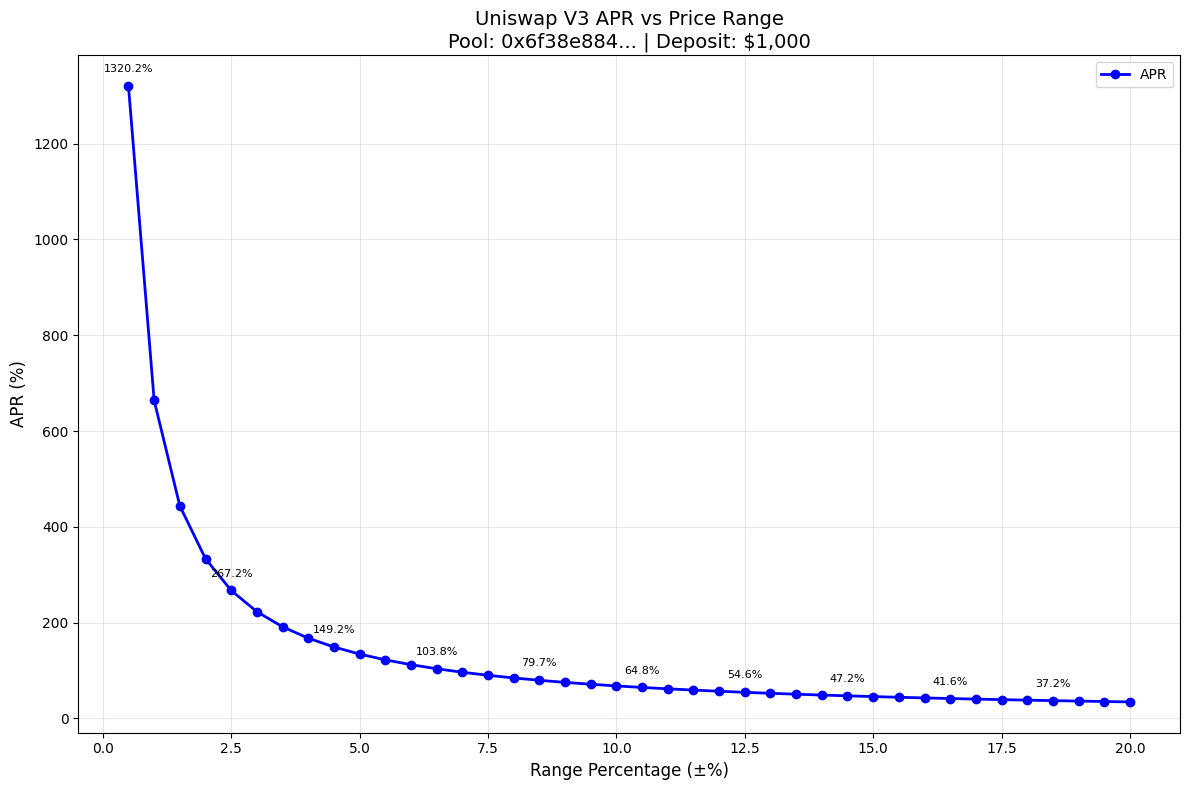

In [114]:
# Create visualization
plt.figure(figsize=(12, 8))

# Plot APR vs Range
plt.plot(results_df['range_percentage'], results_df['apr_percentage'], 
         'bo-', linewidth=2, markersize=6, label='APR')

# Customize the plot
plt.xlabel('Range Percentage (±%)', fontsize=12)
plt.ylabel('APR (%)', fontsize=12)
plt.title(f'Uniswap V3 APR vs Price Range\nPool: {pool_addr[:10]}... | Deposit: ${deposit_amount_usd:,}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations for key data points
for i, row in results_df.iterrows():
    if i % 4 == 0:
        plt.annotate(f'{row["apr_percentage"]:.1f}%', 
                    (row['range_percentage'], row['apr_percentage']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()


In [115]:
# Display the saved CSV file content to verify
print("📄 First few rows of saved CSV:")
saved_df = pd.read_csv(csv_filename)
print(saved_df.head(10))

print(f"\n📊 Summary Statistics:")
print(f"Total ranges tested: {len(saved_df)}")
print(f"Minimum APR: {saved_df['apr_percentage'].min():.2f}% at ±{saved_df.loc[saved_df['apr_percentage'].idxmin(), 'range_percentage']}%")
print(f"Maximum APR: {saved_df['apr_percentage'].max():.2f}% at ±{saved_df.loc[saved_df['apr_percentage'].idxmax(), 'range_percentage']}%")
print(f"Average APR: {saved_df['apr_percentage'].mean():.2f}%")


📄 First few rows of saved CSV:
   range_percentage  apr_percentage
0               0.5     1320.170256
1               1.0      663.822898
2               1.5      443.734926
3               2.0      333.440668
4               2.5      267.181355
5               3.0      222.972246
6               3.5      191.375301
7               4.0      167.666239
8               4.5      149.218378
9               5.0      134.454770

📊 Summary Statistics:
Total ranges tested: 40
Minimum APR: 34.49% at ±20.0%
Maximum APR: 1320.17% at ±0.5%
Average APR: 143.25%
